# Analyzing COVID-19's Effect on Student Engagement for Online Schooling
### Joshua Hess

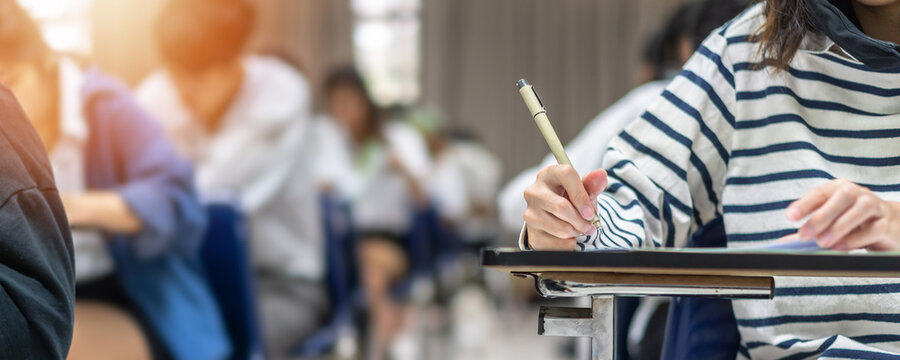

When the COVID-19 Pandemic hit the world in early 2020, one of the fields that was hit the hardest was education. Many schools had to quickly switch from in-person synchronous instruction to remote asynchronous instruction. Students had to learn how to adapt to online schooling, and it had a negative effect in schools across the whole country. One of the things affected the most by COVID was **student engagement**, which measures how 'engaged' or 'focused' a student is on their schoolwork. This project will take a closer look at how COVID affected student engagement throughout late 2019 and 2020. 

Now, let's load in a few of our datasets and take an initial look at them:

In [1]:
# Install additional libraries
!pip install scikit_posthocs

# Mutes FutureWarnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import districts and products info
districts = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
products = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv')

# Print out basic information
print("Districts Dataset:\n")
print(districts.head(5))
print(districts.info())

print("\nProducts Dataset:\n")
print(products.head(5))
print(products.info())

Districts Dataset:

   district_id     state  locale pct_black/hispanic pct_free/reduced  \
0         8815  Illinois  Suburb           [0, 0.2[         [0, 0.2[   
1         2685       NaN     NaN                NaN              NaN   
2         4921      Utah  Suburb           [0, 0.2[       [0.2, 0.4[   
3         3188       NaN     NaN                NaN              NaN   
4         2238       NaN     NaN                NaN              NaN   

  county_connections_ratio    pp_total_raw  
0                [0.18, 1[  [14000, 16000[  
1                      NaN             NaN  
2                [0.18, 1[    [6000, 8000[  
3                      NaN             NaN  
4                      NaN             NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state 

# Cleaning Phase

## Aggregating and Cleaning Engagement Data

Before we can begin a proper analysis, we need to organize our data together. In the `engagement_data` folder, we have `.csv` files of every district, with the district's number being the name of the file. Let's combine all of these CSV's into one overall DataFrame. As we add the data, we'll add an additional column named `district_id` that contains the ID of the district for that particular observation:

In [2]:
# Import libraries for file management
import os
import glob

# Add all engagement_data CSV's into a list
filepath = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data"
files = glob.glob(filepath + "/*.csv")

# Initialize empty list to hold all engagement_data DataFrames
data = []

# For each CSV in 'files', add it to the 'data' list and create a new column 'district_id'
for file in files:
    df = pd.read_csv(file)  # Read in DataFrame
    filename = os.path.splitext(file)  # # Split filename and extension
    df['district_id'] = os.path.basename(filename[0])  # Extract district ID from CSV filename tuple
    data.append(df)  # Add new column to new list

# Concatenate all DataFrames into one 'engagement_data' DataFrame
engagement_data = pd.concat(data)
engagement_data['district_id'] = engagement_data['district_id'].astype('int64')  # Make the district ID's be integers
print(engagement_data.head(10))
print(engagement_data.info())

         time    lp_id  pct_access  engagement_index  district_id
0  2020-01-01  92844.0        0.01              0.68         6345
1  2020-01-01  64838.0        0.01              0.68         6345
2  2020-01-01  94058.0        0.00               NaN         6345
3  2020-01-01  26488.0        0.03             26.21         6345
4  2020-01-01  32340.0        0.01              0.11         6345
5  2020-01-01  95731.0        0.20             40.96         6345
6  2020-01-01  92918.0        0.01              4.54         6345
7  2020-01-01  17307.0        0.00               NaN         6345
8  2020-01-01  96255.0        0.01              0.11         6345
9  2020-01-01  83862.0        0.01              0.11         6345
<class 'pandas.core.frame.DataFrame'>
Index: 22324190 entries, 0 to 41427
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   lp_id             float64
 2   pct_access        float64
 3   engageme

Now we must clean up our data. Let's begin with our `engagement_data` table. First, let's check how many missing values are in each column:

In [3]:
# Print sum of all missing values
print(engagement_data.isnull().sum())

# Check if all observations with a missing value for 'pct_access' also has a missing value for 'engagement_index'
missing_pct = engagement_data[engagement_data['pct_access'].isna()]
print("\nNumber of observations with missing pct_access: " + str(len(missing_pct.index)))

num_of_null_indexes = str(len(missing_pct[missing_pct['engagement_index'].isna()]))
print("Number of missing values for engagement_index: " + num_of_null_indexes)

time                      0
lp_id                   541
pct_access            13447
engagement_index    5378409
district_id               0
dtype: int64

Number of observations with missing pct_access: 13447
Number of missing values for engagement_index: 13447


Notice above that for every time we had a `pct_access` missing, our `engagement_index` was also missing. We can assume that if the `pct_access` is missing, students likely didn't use any learning products that day, which means that there was no `engagement_index` to be measured. For all of these observations, we'll replace both values with 0:

In [4]:
# Conditional statement for both 'engagement_index' and 'pct_access' being missing
both_missing = (engagement_data['pct_access'].isna()) & (engagement_data['engagement_index'].isna())

# Replace NA's in both columns with 0
engagement_data.loc[both_missing, 'pct_access'] = engagement_data.loc[both_missing, 'pct_access'].fillna(0)
engagement_data.loc[both_missing, 'engagement_index'] = engagement_data.loc[both_missing, 'engagement_index'].fillna(0)

# Check missing values
print(engagement_data.isna().sum())

time                      0
lp_id                   541
pct_access                0
engagement_index    5364962
district_id               0
dtype: int64


For the time being, we'll fill in all other NA's with zero. For `lp_id`, we'll drop those observations because the rows with missing values for `lp_id` only make up about 0.0024% of the total dataset. 

In [5]:
# Drop rows where 'lp_id' is missing
engagement_data = engagement_data.dropna(subset=['lp_id'])

# Fill all other NA's with 0
engagement_data = engagement_data.fillna(0)

# Check the DataFrame to verify missing values are taken care of
print(engagement_data.isna().sum())

time                0
lp_id               0
pct_access          0
engagement_index    0
district_id         0
dtype: int64


Lastly, let's format the `time` column as a datetime datatype, which will help with plotting time series later:

In [6]:
# Convert time to datetime
engagement_data['time'] = pd.to_datetime(engagement_data['time'])

## Cleaning District Info Data

Now, we can move onto cleaning our other two DataFrames. Let's begin with `districts_info.csv`. First, let's get a quick glance at the DataFrame and see the number of missing values in each column:

In [7]:
# Print information on districts_info DataFrame
print(districts.info())

# Print missing values
print(districts.isna().sum())

# Print value_counts() for percent columns
for column in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
    print("\nValue counts for " + column + ":\n")
    print(districts.value_counts(column))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     176 non-null    object
 2   locale                    176 non-null    object
 3   pct_black/hispanic        176 non-null    object
 4   pct_free/reduced          148 non-null    object
 5   county_connections_ratio  162 non-null    object
 6   pp_total_raw              118 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB
None
district_id                   0
state                        57
locale                       57
pct_black/hispanic           57
pct_free/reduced             85
county_connections_ratio     71
pp_total_raw                115
dtype: int64

Value counts for pct_black/hispanic:

pct_black/hispanic
[0, 0.2[      116
[0.2, 0.4[     24
[0.4, 0.6[     17
[0.6,

One thing to notice about the above output is that our percentages aren't formatted as specific numbers, but as ranges. This was done to protect the identity of individual school districts, so we can rename these ranges to make it more clear what each percentage is:

In [8]:
# Create dictionaries for renaming
blackhisp_freereduced_dict = {
    '[0, 0.2[' : '0% - 20%',
    '[0.2, 0.4[' : '20% - 40%',
    '[0.4, 0.6[' : '40% - 60%',
    '[0.6, 0.8[' : '60% - 80%',
    '[0.8, 1[' : '80% - 100%'
}

raw_ppl_dict = {
    '[8000, 10000[' : '8k-10k',
    '[10000, 12000[' : '10k-12k',
    '[12000, 14000[' : '12k-14k',
    '[14000, 16000[' : '14k-16k',
    '[16000, 18000[' : '16k-18k',
    '[6000, 8000[' : '6k-8k',
    '[18000, 20000[' : '18k-20k',
    '[20000, 22000[' : '20k-22k',
    '[22000, 24000[' : '22k-24k',
    '[4000, 6000[' : '4k-6k',
    '[32000, 34000[' : '32k-34k'
}

county_ratio_dict = {
    '[0.18, 1[' : '18%-100%',
    '[1, 2[' : '100%-200%'
}

# Rename all observations with dictionaries
districts['pct_black/hispanic'] = districts['pct_black/hispanic'].replace(blackhisp_freereduced_dict)
districts['pct_free/reduced'] = districts['pct_free/reduced'].replace(blackhisp_freereduced_dict)
districts['pp_total_raw'] = districts['pp_total_raw'].replace(raw_ppl_dict)
districts['county_connections_ratio'] = districts['county_connections_ratio'].replace(county_ratio_dict)

# Check DataFrame
print(districts.head())

   district_id     state  locale pct_black/hispanic pct_free/reduced  \
0         8815  Illinois  Suburb           0% - 20%         0% - 20%   
1         2685       NaN     NaN                NaN              NaN   
2         4921      Utah  Suburb           0% - 20%        20% - 40%   
3         3188       NaN     NaN                NaN              NaN   
4         2238       NaN     NaN                NaN              NaN   

  county_connections_ratio pp_total_raw  
0                 18%-100%      14k-16k  
1                      NaN          NaN  
2                 18%-100%        6k-8k  
3                      NaN          NaN  
4                      NaN          NaN  


Unfortunately since the values of all of these columns depend strongly on the details of the school district, there's no reliable way to impute values for these columns. We can assume that this information was not reported when the data was being collected, so let's fill all NA values in this DataFrame with 'Not reported':

In [9]:
# Fill all NA values with 'Not reported'
districts = districts.fillna('Not reported')
print(districts.info())  # Check DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     233 non-null    object
 2   locale                    233 non-null    object
 3   pct_black/hispanic        233 non-null    object
 4   pct_free/reduced          233 non-null    object
 5   county_connections_ratio  233 non-null    object
 6   pp_total_raw              233 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB
None


## Cleaning Educational Product Info

Now, we can clean our last DataFrame for this project: `products`. Just like we did with the `districts` DataFrame, let's look at the missing values:

In [10]:
# Print information on products DataFrame
print(products.info())

# Print missing values
print(products.isna().sum())

# Rename column names to match other DataFrames
rename_dict = {
    'LP ID' : 'lp_id',
    'URL' : 'url',
    'Product Name' : 'name',
    'Provider/Company Name' : 'prov_comp_name',
    'Sector(s)' : 'sector',
    'Primary Essential Function' : 'pef'
}

products = products.rename(columns = rename_dict)  # Replace column names

# Fill all NA's with 'Not reported'
products = products.fillna('Not reported')
print(products.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LP ID                       372 non-null    int64 
 1   URL                         372 non-null    object
 2   Product Name                372 non-null    object
 3   Provider/Company Name       371 non-null    object
 4   Sector(s)                   352 non-null    object
 5   Primary Essential Function  352 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.6+ KB
None
LP ID                          0
URL                            0
Product Name                   0
Provider/Company Name          1
Sector(s)                     20
Primary Essential Function    20
dtype: int64
   lp_id                           url          name         prov_comp_name  \
0  13117    https://www.splashmath.com   SplashLearn          StudyPad Inc.   
1  66933          https

The only missing values in our `products` DataFrame is one missing company name, and 20 missing sectors/PEF's (primary essential functions). There's no way to impute these values, so we'll fill all NA's with 'Not reported,' similar to what we did for the `districts` DataFrame. Now that all three DataFrames are cleaned, we can start analyzing the data to answer the questions we were given for the project.

# Analysis Phase

Before we get into answering the specific questions that the project posed, let's take an initial look at our data and get a feel for what we're working with. First, let's look at the distribution of states that are included in the data:

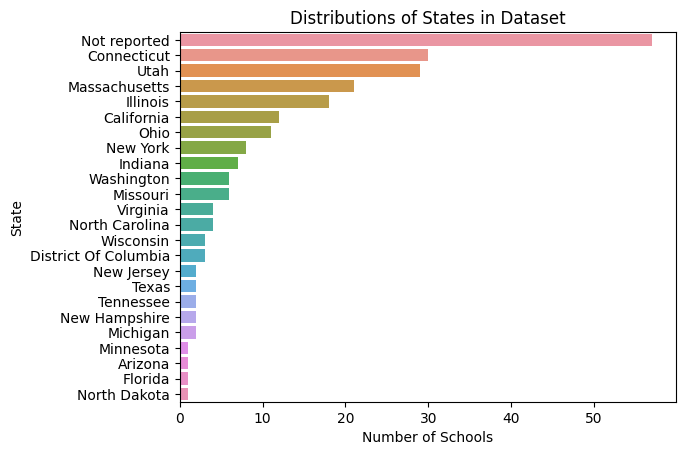

lp_id
95731.0    78295
99916.0    77304
26488.0    76214
28504.0    75814
33185.0    73778
72758.0    72800
32213.0    72321
13496.0    71122
69827.0    70979
69863.0    70566
Name: count, dtype: int64


In [11]:
# Merge engagement_data with products
engagement_products = pd.merge(engagement_data, products, on = 'lp_id', how = 'left')
engagement_total = pd.merge(engagement_products, districts, on = 'district_id', how = 'left')

# Plot the count of all states
sns.countplot(data = districts, y = 'state', order = districts.state.value_counts(ascending = False).index)
plt.xlabel('Number of Schools')
plt.ylabel('State')
plt.title('Distributions of States in Dataset')
plt.show()

# Print ID's of type products
print(engagement_data['lp_id'].value_counts().head(10))

We can see from the above graph that our data is not evenly distributed across all states in the US. The most common states are Connecticut, Utah, and Massachusetts. States like North Dakota, Florida, and Arizona only have 1-2 schools in this dataset, meaning that those states are severely underrepresented. This isn't an immediate issue, but we need to keep this in mind when comparing statistics between states later.

Since there are too many education products to graph on one plot, let's pick three of the top programs:

1. *Google Drive* - Often used by students to hold their files for school projects and assignments.
2. *Wikipedia* - Often used by students as a research resource. Despite many school's stance against using Wikipedia for schoolwork, it still remains the predominant research source for many students.
3. *Google Classroom* - Sometimes used by individual teachers or whole school districts as a Learning Management System (LMS). As an LMS, teachers can make announcements, assign homework, proctor quizzes, and more all through their Google Classroom page.

Let's look at a lineplot of the `engagement_index` for these 3 products over time and make some observations:

     lp_id              name
49   99916      Google Drive
140  13496         Wikipedia
157  32213  Google Classroom


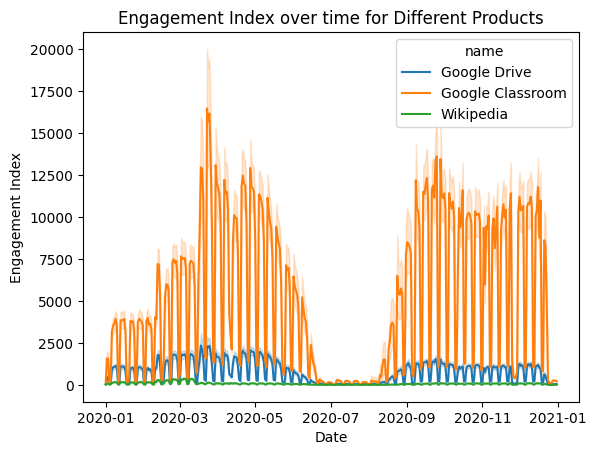

In [12]:
# Narrow down top products
top_ids = [99916.0, 32213.0, 13496.0]
top_products = products.loc[products['lp_id'].isin(top_ids), ['lp_id', 'name']]
print(top_products)

# Filter the engagement_data DataFrame for specific lp_id
engagement_filtered = engagement_total.loc[engagement_total['lp_id'].isin(top_ids), ['time', 'lp_id', 'name', 'engagement_index']]

# Plot time series of engagement_index over time, colored by lp_id
sns.lineplot(data = engagement_filtered, x = 'time', y = 'engagement_index', hue = 'name')
plt.title('Engagement Index over time for Different Products')
plt.xlabel('Date')
plt.ylabel('Engagement Index')
plt.show()

From the above graph, we can make a couple different observations:

- The *up and down* motion of the graph is due to engagement dropping to near zero every school weekend. 
- In late March 2020, the engagement skyrockets. This is likely due to quarantine beginning throughout most of the country at this time. Many students had to quickly switch to online programs. 
- The engagement is initially high at the beginning of quarantine, but there's a steady decline in engagement as the school year draws to a close. Even at its peak, engagement in Fall 2020 never reached the peak it had in March 2020.
- The vast difference between Google Classroom and the other two products is likely due to how it's used. While the others products are used whenever the student needs it for a specific purpose, Classroom is often used almost every day in class, which can explain the higher `engagement_index`.

Now that we've done some initial analysis, let's jump into the specific questions asked by this project.

## Question 1 - "What is the picture of digital connectivity and engagement in 2020?"

To get the "picture" of the relationship between digital connectivity and engagement in 2020, we'll focus on two main variables: `engagement_index` and `county_connections_ratio`. There are two possible values for `county_connections_ratio`: 18%-100% and 100%-200%. A higher ratio suggests more internet connections in the county, which can result in better digital connectivity. Let's calculate some statistics for the differences in engagement between these two ranges:

  county_connections_ratio         avg
0                100%-200%  423.002601
1                 18%-100%  127.888303
2             Not reported  125.483270


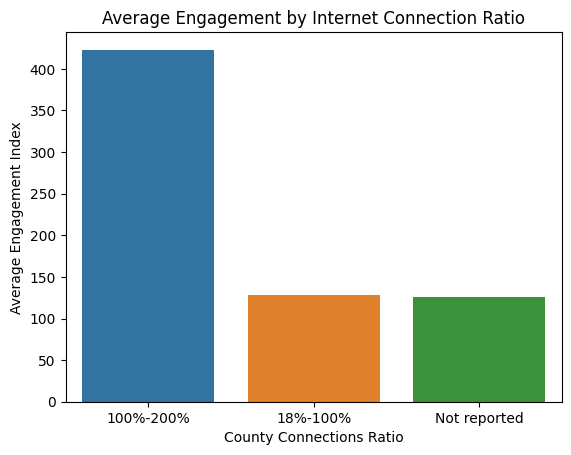

In [13]:
# Calculate average engagement for each range of connectivity
average_engagement_by_ratio = engagement_total.groupby('county_connections_ratio')['engagement_index'].agg('mean').reset_index()
average_engagement_by_ratio = average_engagement_by_ratio.rename(columns = {'engagement_index' : 'avg'})
print(average_engagement_by_ratio)

# Plot average engagement for each range of connectivity
sns.barplot(data = average_engagement_by_ratio, x = 'county_connections_ratio', y = 'avg')
plt.xlabel('County Connections Ratio')
plt.ylabel('Average Engagement Index')
plt.title('Average Engagement by Internet Connection Ratio')
plt.show()

Looking at the above output, we notice a couple interesting things:

1. The average `engagement_index` is much higher for counties with higher connectivity ratios. This is probably because if more students have reliable internet access outside of school, they can login to education products online more often, leading to a higher `engagement_index`. 
2. The districts that did not report their connections ratio had almost the same exact average `engagement_index` as districts with a ratio of 18%-100%. It's possible that these were not reported because they were lower than other districts on average.

To verify this relationship, we will conduct an ANOVA test on the three groups in `county_connections_ratio` to see if there's a significant difference in at least one of the groups (which we can practically assume to be the 100%-200% group). First we must verify that the three conditions for ANOVA are met:

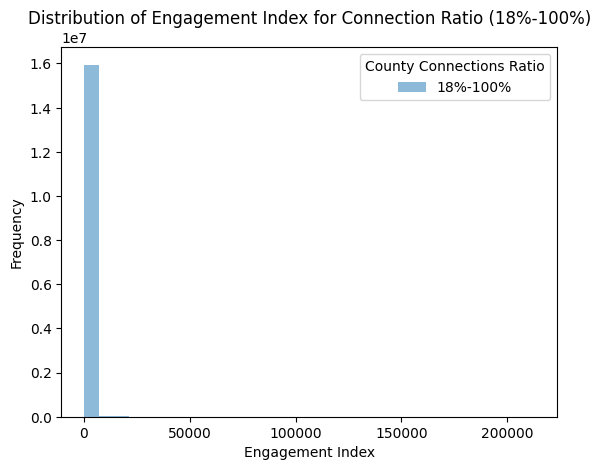

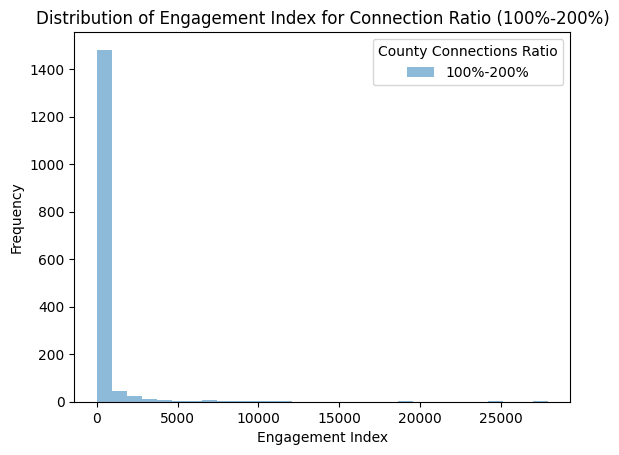

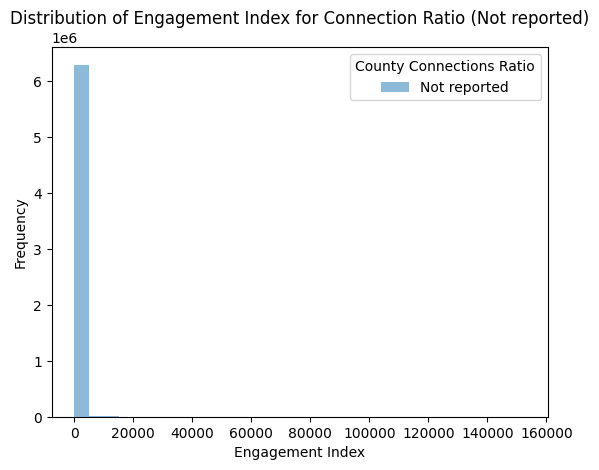

In [14]:
# Reformat 'county_connections_ratio' as a categorical variable
categories = ['18%-100%', '100%-200%', 'Not reported']
engagement_total['county_connections_ratio'] = pd.Categorical(engagement_total['county_connections_ratio'], categories=categories)

# CONDITION 1 - Data is approximately Normal
# Plot each category separately
for category in categories:
    subset = engagement_total[engagement_total['county_connections_ratio'] == category]
    plt.hist(subset['engagement_index'], bins=30, alpha=0.5, label=category)
    plt.title('Distribution of Engagement Index for Connection Ratio (' + str(category) + ")")
    plt.xlabel('Engagement Index')
    plt.ylabel('Frequency')
    plt.legend(title='County Connections Ratio')
    plt.show()

From the above histograms, we can clearly see that our data is **not** approximately normal, so we cannot perform an ANOVA test on these data. However, we can use non-parametric tests instead. One option is the Kruskal-Wallis H test, which measures for significant differences between two or more non-parametric distributions. It has three assumptions:

1. **Independence** - One school district's `engagement_index` does not affect another's, so our data is independent.
2. **Ordinal Scale** - The `engagement_index` means something different in context for high vs. low values, so it works as an ordinal measure.
3. **Similar Distributions** - All three of the above histograms are strongly right-skewed distributions, so they are all sufficiently similar.

Since all three conditions are met, we'll conduct both a Kruskal-Wallis H test to see if there's a significant difference, and Dunn's Test for Posthoc Analysis to verify which of the three `county_connections_ratio` groups is significantly different from the others. Let's quickly define our hypotheses:

$H_0 = $ There is no significant differences between the three groups. \
$H_a = $ There is a significant difference between at least two of the three groups.

Below, we run both tests using python's statistics libraries:

In [15]:
import scipy.stats as stats
import scikit_posthocs as sp

# Extract engagement index values for each category
low_connection = engagement_total[engagement_total['county_connections_ratio'] == '18%-100%']['engagement_index']
high_connection = engagement_total[engagement_total['county_connections_ratio'] == '100%-200%']['engagement_index']
not_reported = engagement_total[engagement_total['county_connections_ratio'] == 'Not reported']['engagement_index']

# Perform the Kruskal-Wallis H test
stat, p = stats.kruskal(low_connection, high_connection, not_reported)
print('Kruskal-Wallis H test result:')
print(f'Statistic: {stat}, p-value: {p}\n')

# If the Kruskal-Wallis test is significant (p < 0.05), proceed with Dunn's test
if p < 0.05:
    # Prepare data for Dunn's test
    data = engagement_total[['engagement_index', 'county_connections_ratio']]
    engagement_values = data['engagement_index']
    group_labels = data['county_connections_ratio']

    # Perform Dunn's test
    dunn_results = sp.posthoc_dunn([engagement_values[group_labels == '18%-100%'],
                                    engagement_values[group_labels == '100%-200%'],
                                    engagement_values[group_labels == 'Not reported']],
                                    p_adjust='bonferroni')

    # Display the results
    print('Dunn\'s test results:')
    print(dunn_results)
else:
    print("Kruskal-Wallis test is not significant. No need for Dunn's test.")

Kruskal-Wallis H test result:
Statistic: 8367.100064570875, p-value: 0.0

Dunn's test results:
     1    2    3
1  1.0  0.0  0.0
2  0.0  1.0  0.0
3  0.0  0.0  1.0


For both the Kruskal-Wallis H test and Dunn's Post Hoc test, we had p-values of 0. As a result, we can reject the null hypothesis and conclude that there is a significant difference between all three groups. One important thing to notice about the results of Dunn's test above is that even though we believed that the 18%-100% group was similar to the 'Not reported' group, Dunn's test states that they have a statistically significant difference.

To answer the first question of this project, `engagement_index` depends strongly on the value of `county_connections_ratio`. The more reliable internet connections a county has, the more likely they are to have a higher average engagement index. This makes sense in context. If more students can access the internet, it makes sense that they would be more engaged in their school work. 

## Question 2 - "What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?"

To see what effect COVID-19 had on online/distance learning, we must first look at how engagement changed over time for multiple different learning products. To get the best data we can, first we'll list out the top 20 learning products in our dataset:

In [16]:
# List out top learning products
top_learning_products = engagement_total['name'].value_counts()
print(top_learning_products.head(20))

name
Google Docs            78295
Google Drive           77304
Google Sheets          75814
Google Forms           73778
Google Calendar        72800
Google Classroom       72321
Wikipedia              71122
Google Sites           70979
Chrome Web Store       70566
Netflix                69053
Khan Academy           66623
Zoom                   66609
Quizlet                64555
Prodigy                63982
Weebly                 63319
TeachersPayTeachers    63284
CNN Student News       62743
ABCya!                 62032
Kahoot!                61870
nytimes.com            61536
Name: count, dtype: int64


Let's pick several of these products to examine more closely. We will choose the following six products to examine:

1. **Google Docs**: As COVID began, the use of Google Docs likely increased a *little*, but many students already used this product a lot before schools closed. There will likely be a small bump in use, but not as large as other products.
2. **Google Classroom**: For this product, I expect to see a **significant** increase in use. Many schools did not utilize learning management systems before COVID, and those that did rarely structured entire classes around these systems. During COVID and since then, the use of LMS's has increased substantially.
3. **Netflix**: While Netflix is not technically an educational product, many students struggled with staying engaged during the early COVID quarantine. If we see a large spike in use for Netflix, we can assume its due to more students watching Netflix and less students staying engaged on their schoolwork.
4. **Zoom**: Zoom became one of the most popular products, not just in education, but in many fields during the beginning of COVID. While Skype had been used for video chatting before, Zoom was more lightweight and simple to use. Many classes gave synchronous online instruction with Zoom, so we can predict that the use of Zoom will skyrocket once COVID begins.
5. **Khan Academy**: While primarily used for math, Khan Academy offers online courses over all sorts of high school subjects. Many teachers that didn't have as strong of technological backgrounds turned to websites like Khan Academy, and began teaching from their curriculum directly. Once COVID begins, we'll likely see a spike in the use of Khan Academy across many different schools.
6. **Kahoot !**: Kahoot is a review tool commonly used to do class-wide reviews in a game-like fashion. While it was commonly used before COVID, we can predict that its usage will increase by a lot once students start doing online learning. 

To take a closer look at these, let's plot time-series line plots of each products `engagement_index` over time, and make observations on what we see:

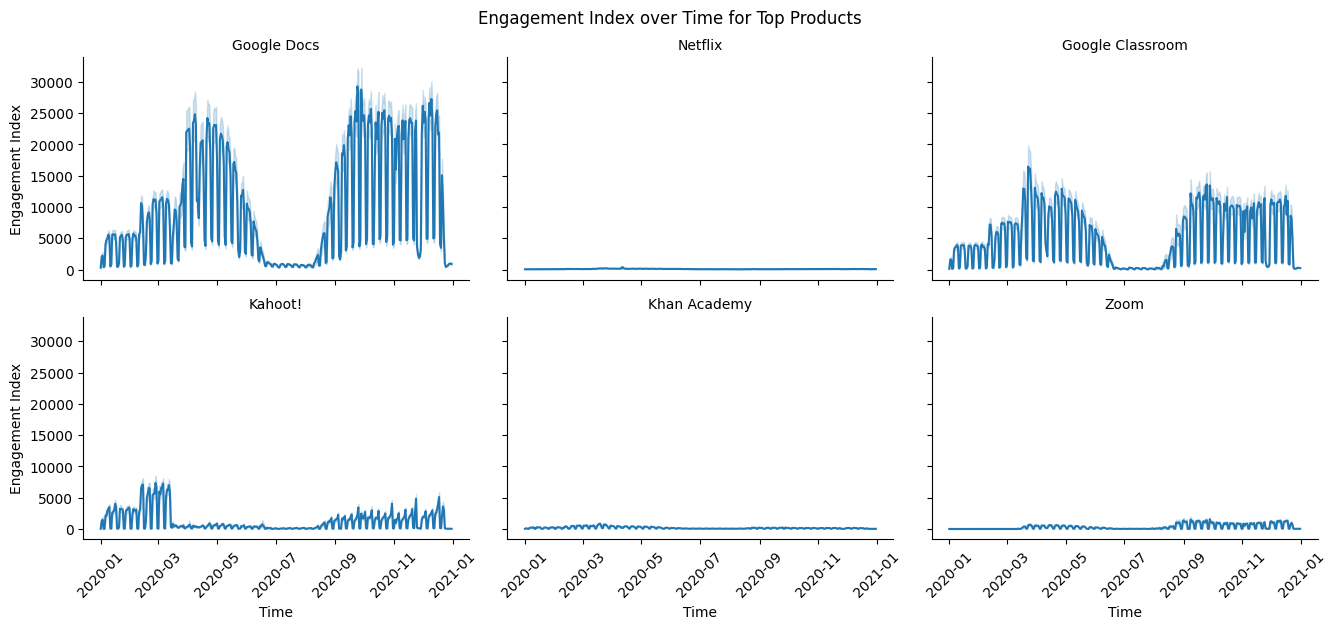

In [17]:
# List the top products and filter our DataFrame
top_products = ['Google Docs', 'Google Classroom', 'Netflix', 'Zoom', 'Khan Academy', 'Kahoot!']
top_product_engagement = engagement_total[engagement_total['name'].isin(top_products)]

# Create FacetGrid of line plots
g = sns.FacetGrid(top_product_engagement, col="name", col_wrap=3, height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x="time", y="engagement_index")

# Add titles and adjust overlaps
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in Seaborn
g.fig.suptitle('Engagement Index over Time for Top Products')

# Rotate the x-axis labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Engagement Index')

# Show the plot 
plt.show()

Let's make a few observations from the above plots:

- Google Docs and Google Classroom were MUCH more commonly used by students than the other four products. The next most used product was Zoom, which wasn't even used until the pandemic began in March 2020.
- Opposite to our previous assumption, Khan Academy actually saw *less* engagement later into the year. There was a small spike in March when the pandemic began, but it stayed relatively low outside of that month.
- Netflix had a tiny bump in engagement right when the pandemic began. This is likely due to students realizing they can be on sites like Netflix more easily when they're at home and not present in school. After this initial bump, it flattened out to near zero engagement for the rest of the year.
- Kahoot was actually used more often before the pandemic. Since it's set up like a competitive game, entire classes would play with each other in-person. It's likely that playing this remotely with a class on Zoom has a lot of technical issues, and doesn't contain the same excitement as the game normally does. After the summer, it increased again in the Fall, but it didn't reach the same heights of engagement it had in Jan-Feb 2020. 

To answer our second question, COVID did have a large effect on student engagement, but it depended on what products the students were engaging with. Products that were specifically designed for remote instruction (Zoom, Google Classroom) saw large increases in engagement once the pandemic began. However, products that were commonly used in-person often saw *decreases* in their overall engagement, such as Kahoot and Khan Academy. 

To answer the second part of the question, we can predict these changes will get stronger as time goes on. In the Fall, certain products (Google Docs, Classroom) had an average engagement similar to when the pandemic first began. These average engagement indices are higher than they were in Jan-Feb 2020, suggesting the the use of these products is much more common in Fall 2020. With all of the technology and support coming out for remote learning every day, it's fair to guess that these products will become more popular past 2020. 

## Question 3 - "How does student engagement with different types of education technology change over the course of the pandemic?"

First, let's look at the different types of education technology, and how common they are:

In [18]:
# Print all values for Primary Essential Function
print(type(products))
print(products['pef'].value_counts())

<class 'pandas.core.frame.DataFrame'>
pef
LC - Digital Learning Platforms                                              74
LC - Sites, Resources & Reference                                            47
LC - Content Creation & Curation                                             36
LC - Study Tools                                                             25
Not reported                                                                 20
LC - Courseware & Textbooks                                                  18
LC - Sites, Resources & Reference - Games & Simulations                      18
LC/CM/SDO - Other                                                            16
LC - Sites, Resources & Reference - Digital Collection & Repository          15
CM - Classroom Engagement & Instruction - Classroom Management               11
LC - Sites, Resources & Reference - Streaming Services                        9
CM - Virtual Classroom - Video Conferencing & Screen Sharing                  

Above, we can see that there are many possible values, but they all fall into one of the three following categories:

1. **LC** - Learning and Curriculum. 
2. **SDO** - School and District Operations.
3. **CM** - Classroom Management.

To see how student engagement varied differently with each category, let's add another column to `products` called `pef_category`, containing which overall category the observation falls into:

In [19]:
# Returns PEF category of given 'pef' value
def categorize_pef(pef):
    if pef.startswith('LC'):
        return 'Learning and Curriculum'
    elif pef.startswith('SDO'):
        return 'School and District Operations'
    elif pef.startswith('CM'):
        return 'Classroom Management'
    else:
        return 'Other'  # For observations without a clear PEF category
    
# Adding the 'pef_category' column
products['pef_category'] = products['pef'].apply(categorize_pef)
engagement_total['pef'] = engagement_total['pef'].astype(str)
engagement_total['pef_category'] = engagement_total['pef'].apply(categorize_pef)

# Check outputs for new columns
print(products['pef_category'].value_counts())  
print(engagement_total['pef_category'].value_counts())

pef_category
Learning and Curriculum           288
Classroom Management               34
School and District Operations     30
Other                              20
Name: count, dtype: int64
pef_category
Other                             11135866
Learning and Curriculum            9400790
Classroom Management                929213
School and District Operations      857780
Name: count, dtype: int64


Now that we have the new column `pef_category` in both DataFrames, we can use it to plot the average `engagement_index` over time for each group. In the code block below, we create a new grouped DataFrame, and we calculate the average `engagement_index` for each grouping of `time` and `pef_category`. Then, we plot a time series line plot to visualize the average engagement for each category over time:

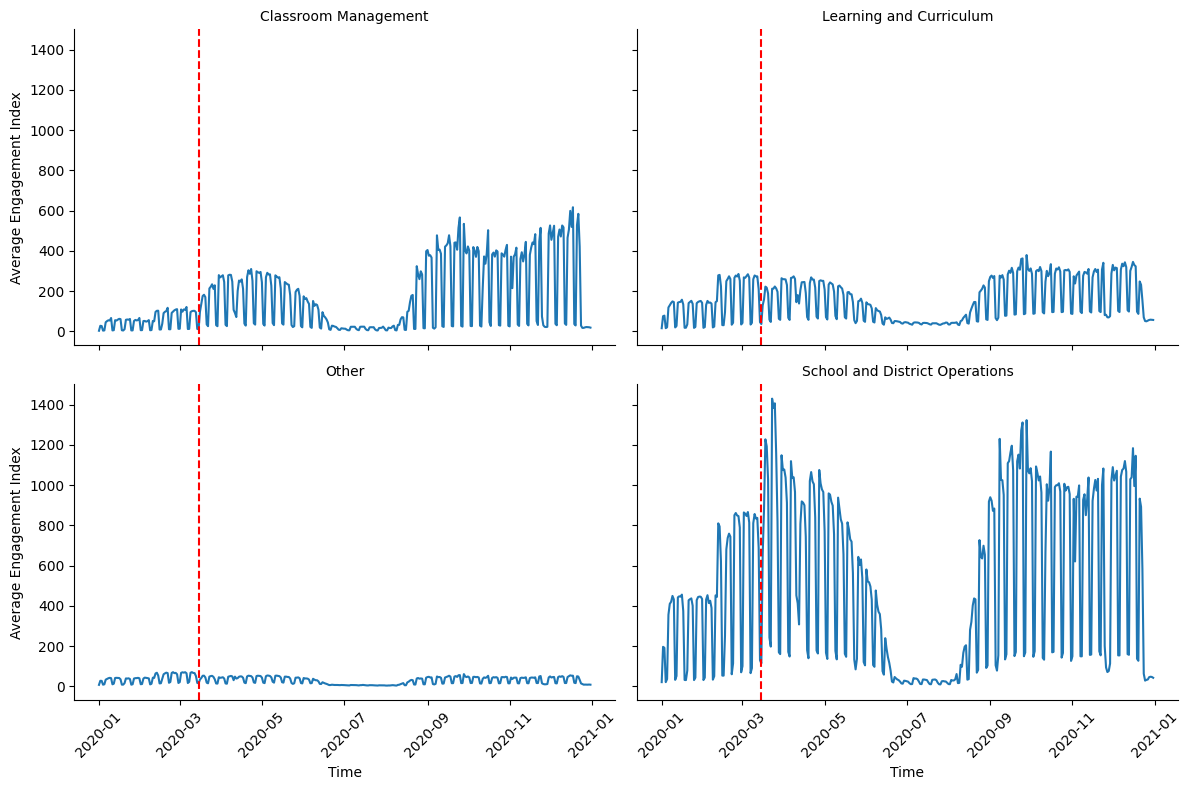

In [20]:
# Group by 'pef_category' and 'time', then calculate the average engagement_index
pef_time_grouped = engagement_total.groupby(['pef_category', 'time']).agg({'engagement_index': 'mean'}).reset_index()

# Create the FacetGrid
g = sns.FacetGrid(pef_time_grouped, col='pef_category', col_wrap=2, height=4, aspect=1.5)

# Date by which most COVID shutdowns had occurred
covid_shutdown = pd.to_datetime('2020-03-15')

# Map the lineplot and COVID line onto the FacetGrid
g.map(sns.lineplot, 'time', 'engagement_index')
g.map(plt.axvline, x = covid_shutdown, color = 'red', linestyle = '--', label = 'Start of Lockdown')

# Add titles and adjust layout
g.set_axis_labels('Time', 'Average Engagement Index')
g.set_titles(col_template='{col_name}')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g.tight_layout()

plt.show()

A couple important observations from the above plot:

- Both Classroom Management and School and District Operations products saw a fairly steep increase right after COVID shutdowns began on March 15th. **Classroom Management** products include Learning Management Systems such as Canvas, and similar products. Many schools had to switch to using these products when the shutdown began. **School and District Operation** products included websites and services that teachers would use for entering grades, managing students, etc.
- Learning and Curriculum products actually saw a brief *decrease* in engagement, which then increased back to its normal engagement rate. When the shutdowns began, many teachers had to quickly learn how to use technologies they'd never been trained on before, which can explain why student engagement dropped initially while teachers were learning how to use their new products.

To answer the overall question, certain educational products that were used for classroom management and school/district operations saw an increase in engagement, while learning and curriculum products saw an initial decrease in engagement and then no significant increases thereafter.

## Question 4 - "How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)? Learning context? Socioeconomic status?"

This question has quite a few layers to it. We will analyze the relationship between student engagement and all of these other factors. We will treat each one as a separate problem, and tackle them one at a time:

### Race and Ethnicity



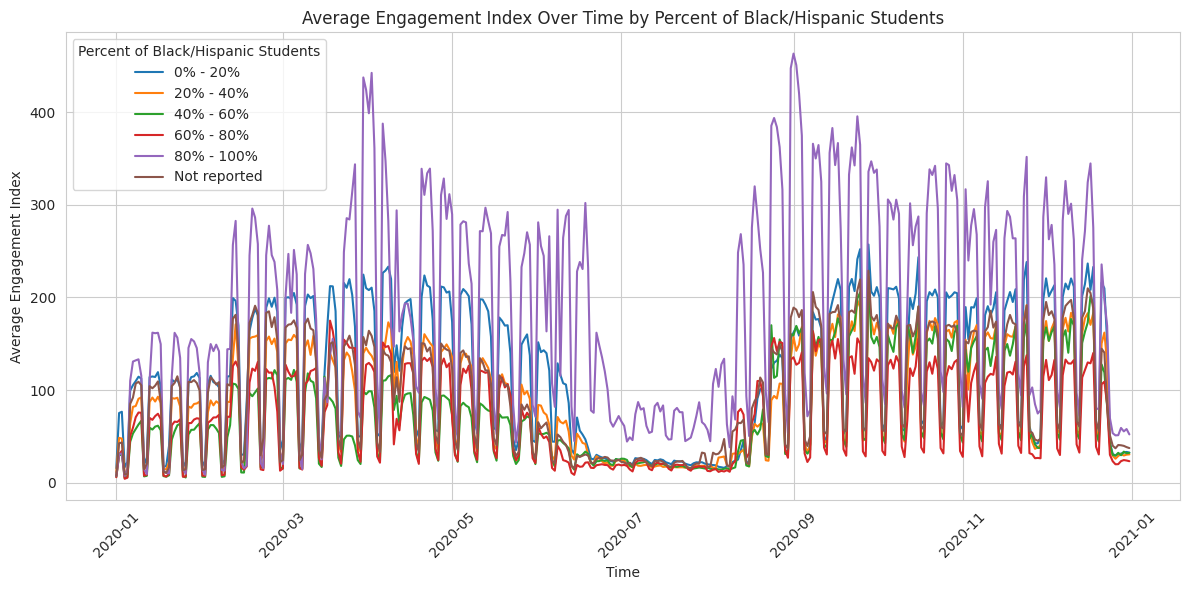

In [21]:
# Group by 'pct_black/hispanic' and 'time', then calculate the average engagement_index
engagement_ethnicity_grouped = engagement_total.groupby(['pct_black/hispanic', 'time']).agg({'engagement_index': 'mean'}).reset_index()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=engagement_ethnicity_grouped, x='time', y='engagement_index', hue='pct_black/hispanic')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Average Engagement Index')
plt.title('Average Engagement Index Over Time by Percent of Black/Hispanic Students')
plt.legend(title='Percent of Black/Hispanic Students')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

One important observation we can make about the above plot is that the highest values for student engagement are coming from school districts with 80%-100% of their student population being black or hispanic. However, schools with 40%-60% and 60%-80% have the lowest engagement on average. To get an idea for why this is, let's look at the proportion of schools in each grouping that are in an urban (city) environment:

In [22]:
# Calculate the total count for each 'pct_black/hispanic' group
total_counts = engagement_total.groupby('pct_black/hispanic').size()

# Filter the DataFrame for 'City' locales
city_counts = engagement_total[engagement_total['locale'] == 'City'].groupby('pct_black/hispanic').size()

# Calculate the percent of schools within a city
proportions = city_counts / total_counts * 100

# Reset index for readability
proportions = proportions.reset_index(name='percentage_city')
print(proportions)

  pct_black/hispanic  percentage_city
0           0% - 20%         7.435682
1          20% - 40%        32.213857
2          40% - 60%        32.360018
3          60% - 80%        58.918061
4         80% - 100%        62.278470
5       Not reported              NaN


Above, we can see that about 62.3% of schools with a student population that is 80%-100% black or hispanic are located within a city. This means that these schools will have more students on average, which will result in a higher `engagement_index`. We can actually see that only about 7.4% of schools with only 0%-20% of black/hispanic students are located within a city. This means smaller school sizes. Since our plot above showed that these schools had the second highest average engagement index, they adjusted the best to the COVID shutdowns. 

One reason that schools with higher percentages of black/hispanic students would struggle more with student engagement is student connectivity. In city school districts, many students don't have reliable access to the internet, which can make it very difficult for them to keep up in online schooling. This disparity between less and more diverse schools isn't only due to the differences in student demographics, but also due to the locale of the school. This leads us into our next section:

### Geography

There's a couple different variables to examine when looking at a school district's geography. One is its locale (which we briefly talked about above), and the other is the state. To get an overall view of how student engagement depended on these two factors, lets plot some bar plots examining the average engagement index for each category:

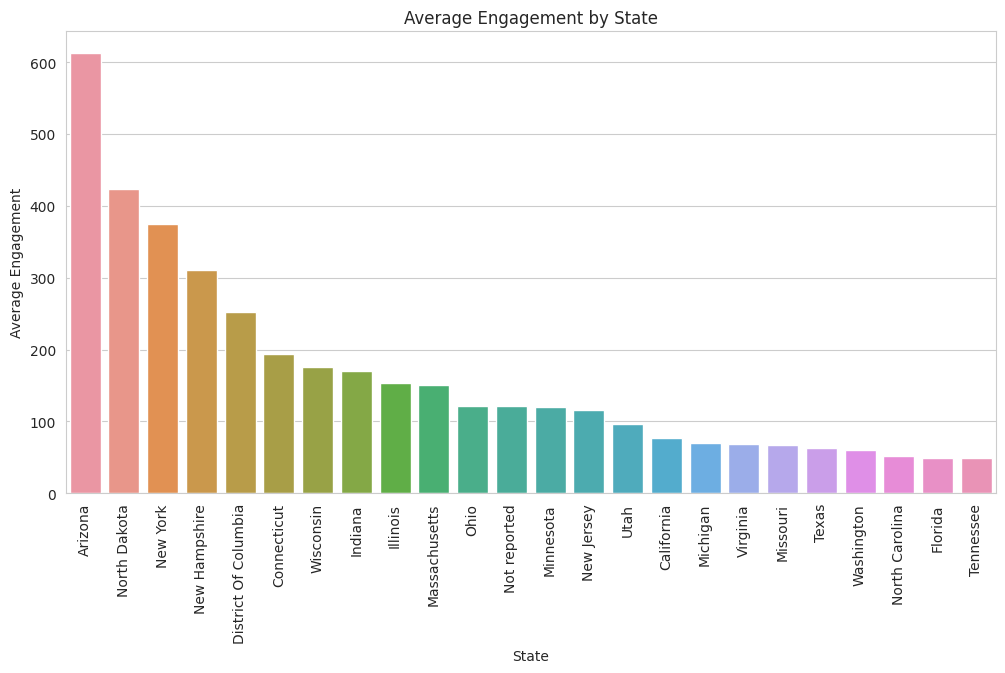

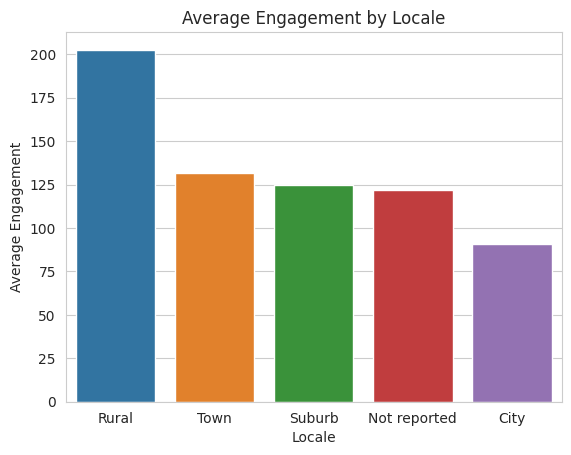

In [23]:
# Create grouped DataFrames calculating average engagement by each variable
engagement_state_grouped = engagement_total.groupby('state').agg({'engagement_index': 'mean'}).reset_index().sort_values('engagement_index', ascending = False)
engagement_locale_grouped = engagement_total.groupby('locale').agg({'engagement_index': 'mean'}).reset_index().sort_values('engagement_index', ascending = False)

# Plot barplot of state vs. average engagement
plt.figure(figsize = (12, 6))
sns.barplot(data = engagement_state_grouped, x = 'state', y = 'engagement_index')
plt.title('Average Engagement by State')
plt.xlabel('State')
plt.ylabel('Average Engagement')
plt.xticks(rotation = 90)  # Rotate State names for readability
plt.show()

# Plot barplot of locale vs. average engagement
sns.barplot(data = engagement_locale_grouped, x = 'locale', y = 'engagement_index')
plt.title('Average Engagement by Locale')
plt.xlabel('Locale')
plt.ylabel('Average Engagement')
plt.show()

One thing to be careful about when interpreting the states graph above is that all of the states have different numbers of schools in the dataset. For example, Arizona and Florida have some of the highest and lowest average engagement respectively, but they both only contain a single school in the dataset. 

However, we can make some meaningful comments about the locale graph. Rural schools had a much higher average engagement, while city schools had on average the lowest engagement, like we discussed earlier. The "not reported" category has a similar average engagement to suburbs and cities, so we can guess that most of the schools that *didn't* report their data were from cities or suburbs. This reinforces our earlier theory that rural school systems often have better connectivity and smaller communities, which leads to higher student engagement. Meanwhile, suburbs and cities often have lower connectivity, which results in lower student engagement.

To make sure this difference is statistically significant, we'll run another Kruskal-Wallis H test, and then Dunn's Posthoc test if needed. We have to use these non-parametric tests because we can't make any meaningful predictions about the underlying distributions of student engagements during COVID. The data is definitely not approximately Normal, so it's easier to use non-parametric tests. Like before, let's define our hypotheses:

$H_0$: There is no significant differences in average engagement between each locale. \
$H_a$: There is at least one significant difference in average engagement between each locale.

In [24]:
# Extract engagement index values for each locale
rural = engagement_total[engagement_total['locale'] == 'Rural']['engagement_index']
town = engagement_total[engagement_total['locale'] == 'Town']['engagement_index']
suburb = engagement_total[engagement_total['locale'] == 'Suburb']['engagement_index']
not_reported = engagement_total[engagement_total['locale'] == 'Not reported']['engagement_index']
city = engagement_total[engagement_total['locale'] == 'City']['engagement_index']

# Perform the Kruskal-Wallis H test
stat, p = stats.kruskal(rural, town, suburb, not_reported, city)
print('Kruskal-Wallis H test result:')
print(f'Statistic: {stat}, p-value: {p}\n')

# If the Kruskal-Wallis test is significant (p < 0.05), proceed with Dunn's test
if p < 0.05:
    # Prepare data for Dunn's test
    data = engagement_total[['engagement_index', 'locale']]
    engagement_values = data['engagement_index']
    group_labels = data['locale']

    # Perform Dunn's test
    dunn_results = sp.posthoc_dunn([engagement_values[group_labels == 'Rural'],
                                    engagement_values[group_labels == 'Town'],
                                    engagement_values[group_labels == 'Suburb'],
                                    engagement_values[group_labels == 'City'],
                                    engagement_values[group_labels == 'Not reported']],
                                    p_adjust='holm')

    # Display the results
    print('Dunn\'s test results:')
    print(dunn_results)
else:
    print("Kruskal-Wallis test is not significant. No need for Dunn's test.")

Kruskal-Wallis H test result:
Statistic: 123737.48390635465, p-value: 0.0

Dunn's test results:
     1    2    3    4    5
1  1.0  0.0  0.0  0.0  0.0
2  0.0  1.0  0.0  0.0  0.0
3  0.0  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  1.0  0.0
5  0.0  0.0  0.0  0.0  1.0


According to our significant test results above, we can reject the null hypothesis. We can also use Dunn's test results to see that there's actually a statistically significant difference between every locale, which likely arises from the different number of schools contained in each locale for our dataset. 

### Socioeconomic Status (SES)

We will treat this similar to our section over race and ethnicity. In education, schools typically do not report the socioeconomic status of their students due to ethical reasons. However, many schools use the percent of students who recieve free or reduced-price lunches as a proxy statistic for the percent of students of a lower SES. Similar to our variable for the percent of black and hispanic students, we have 6 possible values for this variable:

In [25]:
print(engagement_total['pct_free/reduced'].value_counts())

pct_free/reduced
Not reported    7332840
0% - 20%        4819697
20% - 40%       4516311
40% - 60%       3858856
60% - 80%       1580285
80% - 100%       215660
Name: count, dtype: int64


Below, we'll group our data by the percent of free/reduced lunches and the date, and then plot the average engagement index throughout 2020:

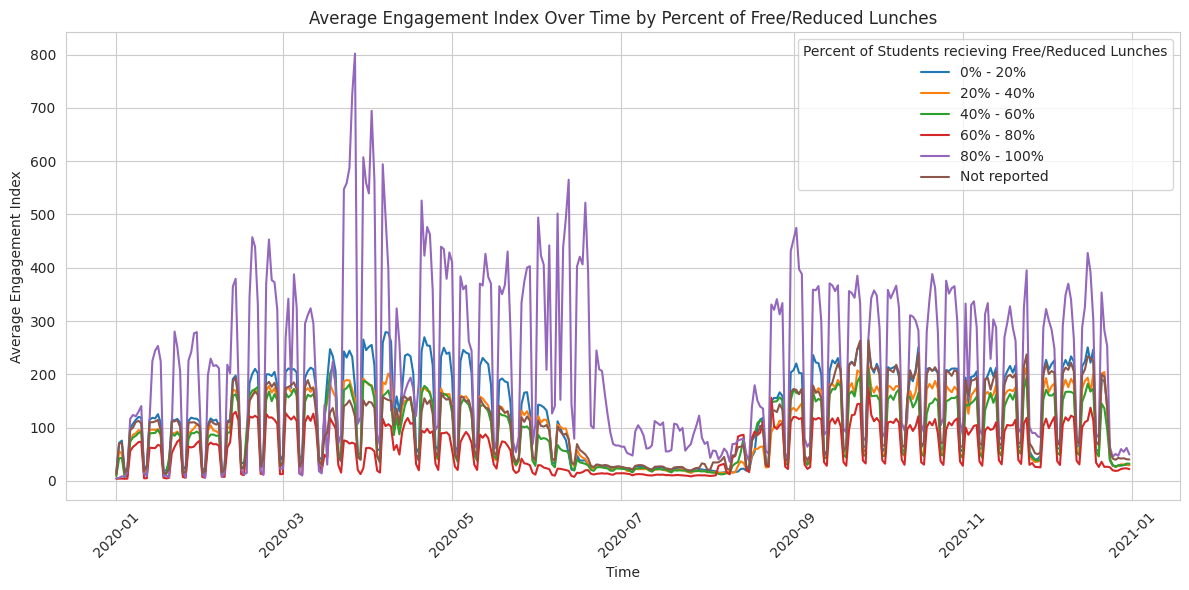

In [26]:
# Group by 'pct_free/reduced' and 'time', then calculate the average engagement_index
engagement_ses_grouped = engagement_total.groupby(['pct_free/reduced', 'time']).agg({'engagement_index': 'mean'}).reset_index()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=engagement_ses_grouped, x='time', y='engagement_index', hue='pct_free/reduced')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Average Engagement Index')
plt.title('Average Engagement Index Over Time by Percent of Free/Reduced Lunches')
plt.legend(title='Percent of Students recieving Free/Reduced Lunches')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [27]:
# Calculate the total count for each 'pct_free/reduced' group
total_counts = engagement_total.groupby('pct_free/reduced').size()

# Filter the DataFrame for 'City' locales
city_counts = engagement_total[engagement_total['locale'] == 'City'].groupby('pct_free/reduced').size()

# Calculate the percent of schools within a city
proportions = city_counts / total_counts * 100

# Reset index for readability
proportions = proportions.reset_index(name='percentage_city')
print(proportions)

  pct_free/reduced  percentage_city
0         0% - 20%         7.961517
1        20% - 40%         6.310836
2        40% - 60%        37.676788
3        60% - 80%        53.791816
4       80% - 100%        23.558379
5     Not reported         5.223829


One interesting pattern is that the lineplot of each category of free/reduced lunches is very similar to the lineplot for percentages of black/hispanic students. Schools with 80-100% of their students on free or reduced lunches have the highest average engagement, while the engagement decreases from 0-20% to 60-80% after that. Based on this pattern, I also checked the percentage of each category that had city schools. Surprisingly, the largest proportions of city schools belonged to the 60-80% and 40-60% groups respectively. 

One theory is that schools in rural locales also typically have lower-income families attending those schools, so let's also check the proportion of rural schools in each category:

In [28]:
# Calculate the total count for each 'pct_free/reduced' group
total_counts = engagement_total.groupby('pct_free/reduced').size()

# Filter the DataFrame for 'Rural' locales
rural_counts = engagement_total[engagement_total['locale'] == 'Rural'].groupby('pct_free/reduced').size()

# Calculate the percent of schools within a rural locale
proportions = rural_counts / total_counts * 100

# Reset index for readability
proportions = proportions.reset_index(name='percentage_rural')
print(proportions)

  pct_free/reduced  percentage_rural
0         0% - 20%         19.139274
1        20% - 40%          7.572198
2        40% - 60%         19.097266
3        60% - 80%          7.999949
4       80% - 100%               NaN
5     Not reported          2.393316


As we can see above, about 43.8% of rural schools grant free/reduced lunches to 80-100% of their students, which is much higher than the next percentage: 19.14% with 0-20% of students recieving free/reduced lunches. This means that unlike the race and ethnicity section, we can assume that the largest amount of free/reduced lunches are granted in both **City Schools** and **Rural Schools**. 

# Final Conclusions

Below, we summarize our answers to each of the assigned questions:

### *What is the picture of digital connectivity and engagement in 2020?*

Digital connectivity is a measure of how many residents of a community have reliable access to the internet. According to the data, schools with lower connectivity had lower engagement on average, while schools with higher connectivity had higher engagement. This is because if a student doesn't have reliable access to the internet, they will naturally have lower engagement due to not being able to access educational products online. According to our statistical analysis, there is a statistically significant difference in the amount of student engagement between low connectivity and high connectivity schools. 

### *What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?*

The effect COVID-19 had on online and distance learning was complex and varied. The effect depended on what the educational product was originally intended for. Products that were intended for remote use (Zoom, Google Classroom) saw a large bump in engagement, since students could more reliably use these products once COVID shutdowns began. But products that were intended for in-class use (Khan Academy, Kahoot) saw a decrease or stagnation in engagement, because teachers and students had to work to adapt those tools to remote learning. 

### *How does student engagement with different types of education technology change over the course of the pandemic?*

Online learning comprises of different products that aim to achieve different goals. Some products help teachers manage their classrooms, some guide students through prepared curriculums or help teach concepts, and some help the schools manage their operations. Products that were used for classroom or school operations management saw a large increase, because many schools had to completely switch over to these services once shutdowns began. Products that were intended for teaching students saw a slight decrease once shutdowns began due to many teachers struggling to adapt them to online learning.

### *How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)? Learning context? Socioeconomic status?*

We inspected the relationship between student engagement and the following topics:

1. Race and Ethnicity: We can see from our analysis that with the exception of city schools with their large student populations, student engagement generally decreased as the percent of black/hispanic students increased. This is likely due to schools with higher proportions of black/hispanic students having lower internet connectivity on average, which can explain why the engagement for those schools is lower.

2. Locale: Our analysis showed that as the general population of a locale increased, its average student engagement decreased. Rural locales had more engagement on average, while city locales had lower engagement on average. This is due to rural school systems often having smaller, more tight-knit communities where it's easier to manage students. Additionally, larger populations of students means more students will not engage with school content, which drags down the average engagement even further.

3. Socioeconomic Status (SES): The pattern of student engagement between groups of free/reduced lunch students was very similar to the pattern with race and ethnicity. One important detail we discovered was that the schools that offered the most free/reduced lunches were in rural communities (due to more lower-income families) and in city communities (due to larger rates of poverty and lower SES families), which can affect analyzing student engagement for both groups.

Overall, COVID had a huge effect on student engagement as a whole. More emphasis was put on remote-learning educational products after COVID shutdowns began, and they continued to be used even after schools opened again later in the year. It's likely that the changes we saw happen to the educational system in 2020 will continue to affect how education is done in the years to come. 